# U-Net pipeline demo

In [1]:
import sys; sys.path.append('./preprocessor_module')
import matplotlib.pyplot as plt
import numpy as np
import h5py

from preprocessor_module import (
    constants             as ct,
    list_dicom_files      as lf,
    dicom_transformations as dt,
    dicom_preprocessor    as dp,
)

## 1. Preprocessing phase

### 1.1. Preprocessing step-by-step

In [2]:
# Provide the path to the data directory
data_dir = './data'

# List all `.dcm` files in the data directory
all_files_meta = lf.ListDicomFiles(data_dir)()

# Select some `.dcm` file
some_file = all_files_meta[0]

# Extract file metadata
(
    dicom_filepath,
    points_filepath,
    dataset_name,
    subject_id,
    subject_visit,
) = \
    some_file

In [3]:
# Open the HDF5 file to which we want to write the preprocessing output.
# The writing will occur later.
hdf5_filepath = './my_hdf5_file.h5'
hdf5_file_obj = h5py.File(hdf5_filepath, 'w') #  open(hdf5_filepath, 'w')

In [4]:
# Create a `DicomContainer` for the selected file
# Transforms are applied on this "container"
dicom_container = dt.DicomContainer(
    dicom_filepath,
    points_filepath,
    dataset_name,
    subject_id,
    subject_visit,
    hdf5_file_obj,
)

In [5]:
# Load the DICOM image (opens the file)
dt.LoadDicomObject()(dicom_container)
print(dicom_container.dicom_file_object)

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 202
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Computed Radiography Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.392.200036.9125.9.0.168783648.1477259264.1662249901
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.840.113704.7.0.2
(0002, 0013) Implementation Version Name         SH: 'GDCM 2.4.5'
(0002, 0016) Source Application Entity Title     AE: 'gdcmanon'
-------------------------------------------------
(0008, 0008) Image Type                          CS: ['DERIVED', 'PRIMARY', 'POST_PROCESSED', '', '', '', '', '', '100000']
(0008, 0012) Instance Creation Date              DA: '20090101'
(0008, 0013) Instance Creation Time              TM: ''
(0008, 0016) SOP Class UID                       UI: C

Pixel array ndim: 3
Pixel array shape: (1, 3520, 4280)
Pixel spacing: ('0.1', '0.1')


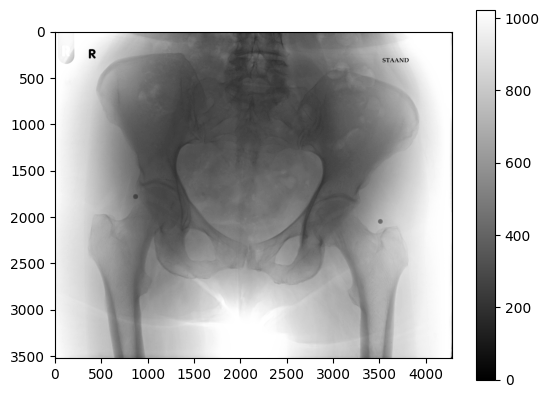

In [6]:
# Get the image pixel array.
dt.GetPixelArray()(dicom_container)

# Get the pixel spacing of original image (mm/pixel).
dt.GetSourcePixelSpacing()(dicom_container)

# Note that the image has a dimension added to it 
# to later match the dimension of the combined segmentation mask.
print(f'Pixel array ndim: {dicom_container.pixel_array.ndim}')
print(f'Pixel array shape: {dicom_container.pixel_array.shape}')

print(f'Pixel spacing: {dicom_container.source_pixel_spacing}')

plt.imshow(dicom_container.pixel_array[0], 'grey')
plt.colorbar()
pass

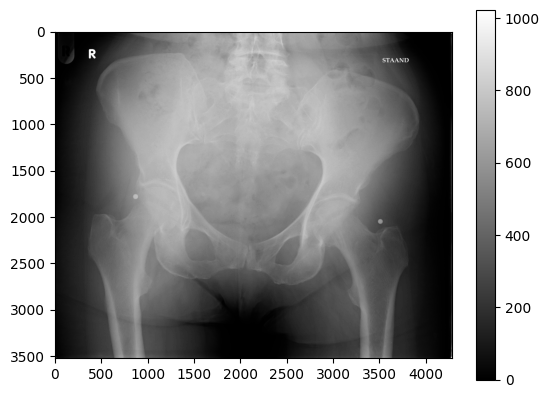

In [7]:
# Images may only be stored with either MONOCHROME1 (black and white)
# or MONOCHROME2 (white and black) as their photometric interpretation.
# If stored as MONOCHROME1, pixel intensities are flipped to MONOCHROME2.
dt.CheckPhotometricInterpretation()(dicom_container)
plt.imshow(dicom_container.pixel_array[0], 'grey')
plt.colorbar()
pass

In [8]:
# Our DICOM images must have their `VOILUT Function` property set to `LINEAR`.
dt.CheckVoilutFunction()(dicom_container)
pass

#### Rescaling

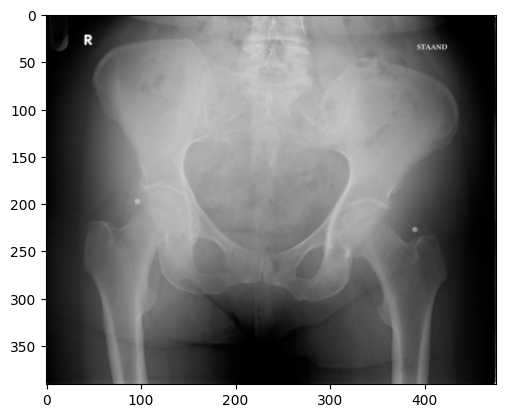

<module 'matplotlib.pyplot' from 'c:\\Users\\drago\\AppData\\Local\\Programs\\Python\\Python312\\Lib\\site-packages\\matplotlib\\pyplot.py'>

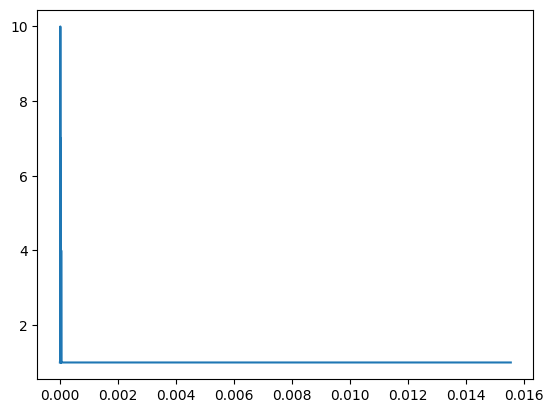

In [9]:
# Rescale image to a target pixel spacing.
# (NOTE: anisotropic pixel spacing is not supported).
target_pixel_spacing = (0.9, 0.9)
dt.RescaleToTargetPixelSpacing(target_pixel_spacing)(dicom_container)
plt.imshow(dicom_container.pixel_array[0], 'grey')
plt.show()

intensities, frequencies = np.unique(dicom_container.pixel_array, return_counts=True)
plt.plot(intensities[3:], frequencies[3:])
pass

#### 1.1.1. Intensity Normalization

In [10]:
# Select two other `.dcm` files to compare with.
other_file_1 = all_files_meta[3]
other_file_2 = all_files_meta[7]

# Create containers for the two files.
other_container_1 = dt.DicomContainer(
    *other_file_1,
    hdf5_file_obj,
)
other_container_2 = dt.DicomContainer(
    *other_file_2,
    hdf5_file_obj,
)

# Apply the same transformations as before.
# To chain multiple transformations, one can use the `CombineTransformations`.
combined_transf = dt.CombineTransformations([
    dt.LoadDicomObject(),
    dt.GetPixelArray(),
    dt.GetSourcePixelSpacing(),
    dt.CheckPhotometricInterpretation(),
    dt.CheckVoilutFunction(),
])
combined_transf(other_container_1)
combined_transf(other_container_2)
pass

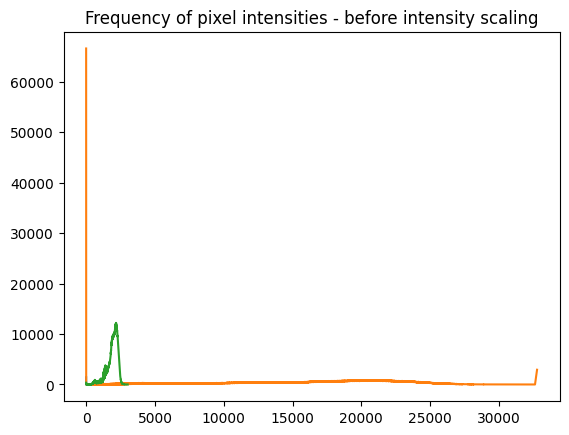

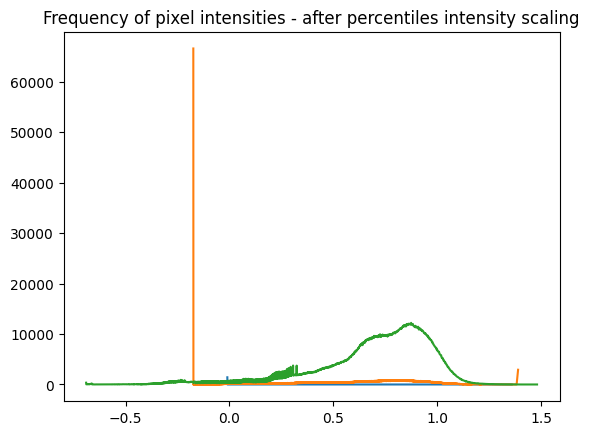

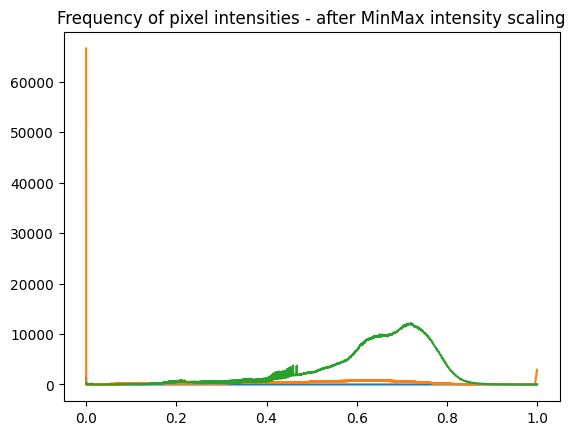

In [11]:
# Image without any intensity normalization applied.
plt.title('Frequency of pixel intensities - before intensity scaling')
for container in (dicom_container, other_container_1, other_container_2):
    intensities, frequencies = np.unique(container.pixel_array, return_counts=True)
    plt.plot(intensities, frequencies)
plt.show()

# Apply [5, 95] percentiles intensity normalization.
percentiles_norm = dt.PercentilesIntensityNormalization((5, 95))

plt.title('Frequency of pixel intensities - after percentiles intensity scaling')
for container in (dicom_container, other_container_1, other_container_2):
    percentiles_norm(container)
    intensities, frequencies = np.unique(container.pixel_array, return_counts=True)
    plt.plot(intensities, frequencies)
plt.show()


# Apply min-max intensity normalization.
min_max_norm = dt.MinMaxIntensityNormalization()

dt.MinMaxIntensityNormalization()(dicom_container)
intensities, frequencies = np.unique(dicom_container.pixel_array, return_counts=True)
plt.title('Frequency of pixel intensities - after MinMax intensity scaling')
for container in (dicom_container, other_container_1, other_container_2):
    min_max_norm(container)
    intensities, frequencies = np.unique(container.pixel_array, return_counts=True)
    plt.plot(intensities, frequencies)
plt.show()
pass

#### Padding

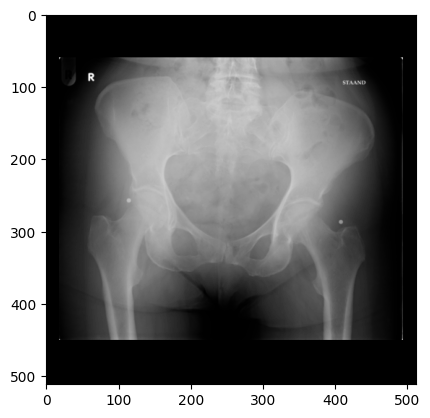

In [12]:
# Pad image to reach target image shape.
# (NOTE: if image shape is larger than the 
# target shape, the image is discarded).
target_shape = (512, 512)
dt.PadSymmetrically(target_shape)(dicom_container)
plt.imshow(dicom_container.pixel_array[0], 'grey')
plt.show()

#### 1.1.3. Segmentation mask

In [17]:
# Get the BoneFinder points generated for the our image
# from the corresponding `.dcm.pts` file.
dt.GetBoneFinderPoints()(dicom_container)
print('BoneFinder points (list of pixel coordinates in mm):\n', dicom_container.bonefinder_points)

BoneFinder points (list of pixel coordinates in mm):
 [[ 53.6651 279.942 ]
 [ 49.7916 263.669 ]
 [ 44.1777 250.489 ]
 [ 36.395  240.462 ]
 [ 35.737  226.786 ]
 [ 38.7195 212.586 ]
 [ 42.6801 197.589 ]
 [ 55.6535 198.126 ]
 [ 61.4114 203.198 ]
 [ 64.9301 203.347 ]
 [ 67.8373 203.803 ]
 [ 71.0493 203.34  ]
 [ 74.1381 202.021 ]
 [ 76.951  200.305 ]
 [ 79.2123 197.793 ]
 [ 81.5644 194.394 ]
 [ 83.5482 189.956 ]
 [ 85.3777 184.446 ]
 [ 87.2998 179.579 ]
 [ 91.3016 173.976 ]
 [ 96.53   170.818 ]
 [106.348  167.656 ]
 [116.782  168.776 ]
 [126.58   174.578 ]
 [132.649  184.852 ]
 [133.981  198.649 ]
 [127.875  210.895 ]
 [115.124  217.977 ]
 [107.02   220.893 ]
 [101.372  231.761 ]
 [ 98.1117 244.033 ]
 [ 97.0247 258.407 ]
 [102.623  265.025 ]
 [ 99.4402 281.166 ]
 [ 91.7031 286.049 ]
 [ 54.359  197.108 ]
 [ 62.3686 198.873 ]
 [ 64.7717 201.477 ]
 [ 64.6997 205.786 ]
 [ 67.7833 223.431 ]
 [ 87.5127 177.252 ]
 [ 94.7839 186.54  ]
 [102.115  197.197 ]
 [108.047  207.23  ]
 [112.936  216.965 ]
 

Segmentation masks shapes:
    - right: (3, 512, 512);
    - left: (3, 512, 512);



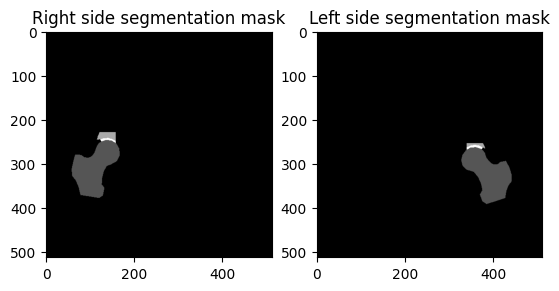

In [14]:
# Draw segmentation masks for both the right and left sides of the hip using BoneFinder points.
# There is the option of including or not the background mask.
dt.GetSegmentationMasks(include_background_mask = False)(dicom_container)

print(
    f'Segmentation masks shapes:\n'
    f'    - right: {dicom_container.right_segmentation_mask.shape};\n'
    f'    - left: {dicom_container.left_segmentation_mask.shape};\n'
)

# Show the overlapped masks.
plt.subplot(1, 2, 1)
plt.title('Right side segmentation mask')
plt.imshow(sum((idx + 1) * mask for idx, mask in enumerate(dicom_container.right_segmentation_mask)), 'grey')

plt.subplot(1, 2, 2)
plt.title('Left side segmentation mask')
plt.imshow(sum((idx + 1) * mask for idx, mask in enumerate(dicom_container.left_segmentation_mask)), 'grey')
pass

#### 1.1.4. Writing to HDF5

In [15]:
# Write image, right side segmentation mask metadata from the `DicomContainer` to the HDF5 file
dt.AppendDicomToHDF5('right')(dicom_container)
pass

In [16]:
# To write the segmentation mask for the left side,
# we need to first flip the image and the masks,
# such that the left hip and the left hip mask are 
# now on the right side of the hip.
dt.Flip(axis=-1)(dicom_container)

# Write image, left side segmentation mask metadata from the `DicomContainer` to the HDF5 file
dt.AppendDicomToHDF5('left')(dicom_container)
pass

### 1.2 Full preprocessing pipeline